In [1]:
import pandas as pd
import numpy as np
import pysam

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")

from akita_utils.dna_utils import dna_seq_rc

2024-06-14 09:44:11.941264: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 09:44:11.968685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 09:44:11.968720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 09:44:11.969491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-14 09:44:11.975421: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import read_and_average_virtual_exp
from analysis_utils import (collect_flanked_sequences, 
                            reorder_by_hamming_dist, 
                            prepare_nt_count_table, 
                            plot_seq_matrix,
                            plot_logo_from_counts)

In [3]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"

In [4]:
# reading data, averaging over targets and backgrounds
df = read_and_average_virtual_exp("/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_singletons", stat_to_average=stat_of_analysis_interest)

reading h5 files to dataframes
averaging over targets
averaging over backgrounds
collecting data for SCD


In [5]:
# num of sites the further analysis is based on
num_sites = 150
sites = df.sort_values(by=[stat_of_analysis_interest], ascending=False)[:num_sites].reset_index()

## Saving 150 top sequences

In [6]:
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa" 

In [7]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [8]:
flank_to_include = 30

In [12]:
print("\n ACFT ")


 ACFT 


In [14]:
with open("./150_top_insertion_30bp_flanks.fasta", "w") as outfile:

    for s in sites.itertuples():
        dna_seq = genome_open.fetch(
                    s.chrom, s.start - flank_to_include, s.end + flank_to_include).upper()
        if s.strand == "-":
            dna_seq = dna_seq_rc(dna_seq)
        identifier = f"{s.chrom}_{s.start}_{s.end}_{s.strand}"
        
        # Writing data to a file
        outfile.write(">")
        outfile.write(identifier)
        outfile.write("\n")
        outfile.write(dna_seq)
        outfile.write("\n")

In [15]:
genome_open.close()

## Visualizing Sequences as Matrix

In [16]:
dna_matrix = collect_flanked_sequences(sites)

In [17]:
dna_matrix

array([[2, 1, 0, ..., 2, 1, 3],
       [0, 1, 0, ..., 3, 1, 3],
       [3, 3, 3, ..., 1, 1, 3],
       ...,
       [3, 3, 3, ..., 3, 1, 3],
       [0, 0, 2, ..., 1, 1, 0],
       [3, 1, 0, ..., 0, 0, 2]], dtype=uint8)

/home1/smaruj/akitaX1-analyses/utils/analysis_utils.py:94: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  scipy.cluster.hierarchy.linkage(seq_dist)


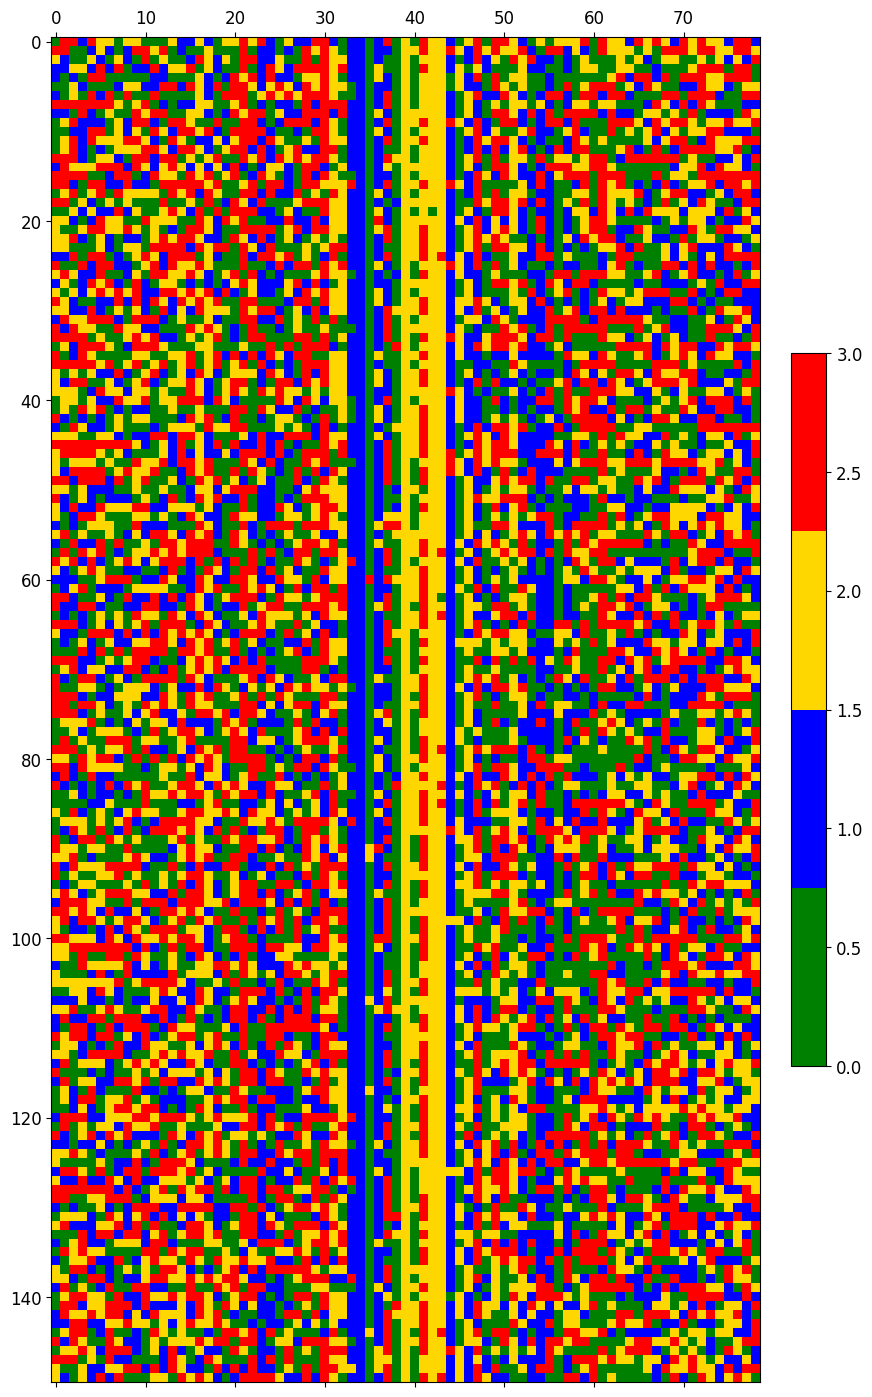

In [18]:
plot_seq_matrix(dna_matrix)

/tmp/SLURM_22239378/ipykernel_239802/3241043649.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels.astype(int))


[]

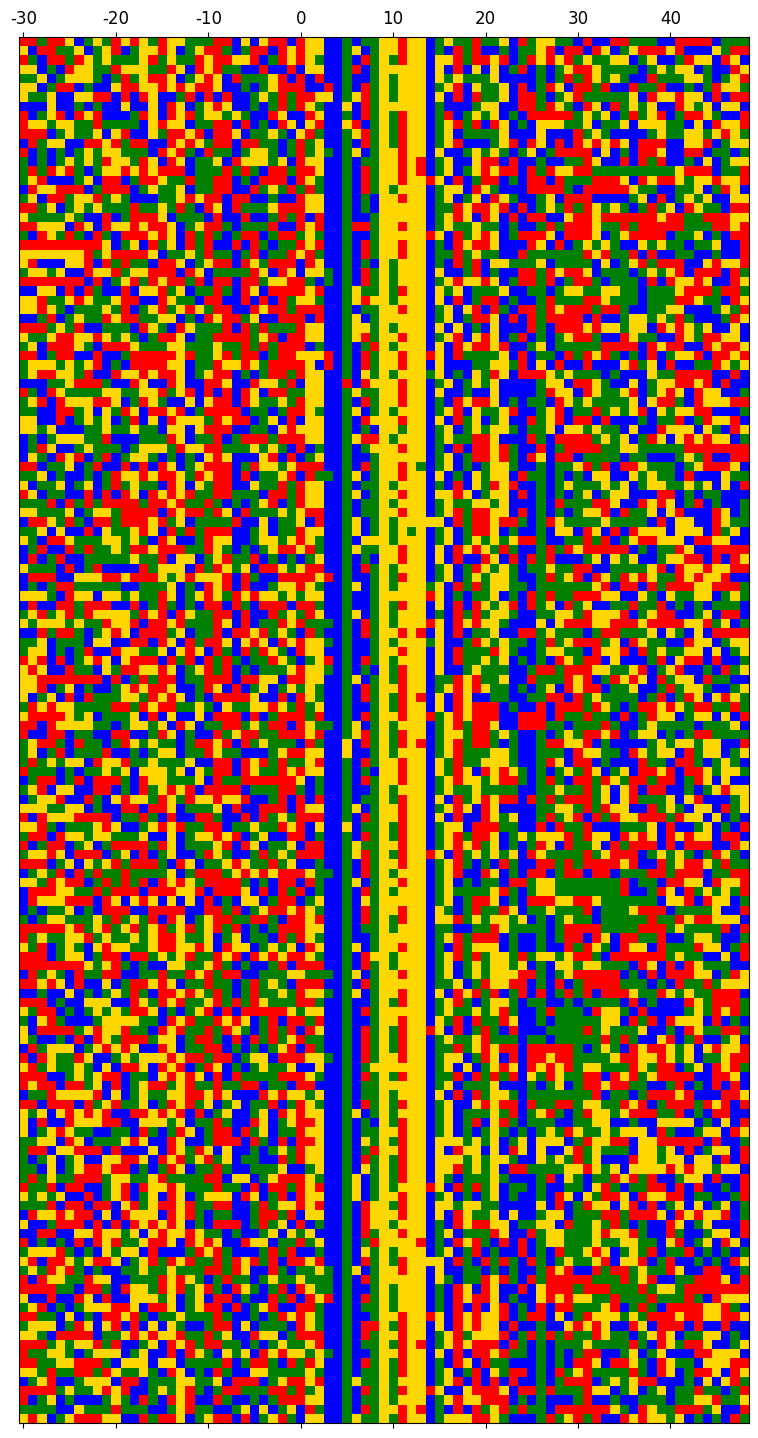

In [19]:
cluster_by_hamming=True
sub_index=(-30, -1)
    
# colormap matching logo colors
cmap_acgt = colors.ListedColormap([
    'green', #a green
    'blue', #c blue
    'gold', #g gold
    'red' #t red
])

if cluster_by_hamming:
    dna_matrix = reorder_by_hamming_dist(dna_matrix, sub_index=sub_index)

plt.figure(figsize=(10,18))
im = plt.matshow(
    dna_matrix, 
    cmap=cmap_acgt,
    fignum=False) 

# Shift x-ticks by -30
ax = plt.gca()  # Get the current axes
current_xticks = ax.get_xticks()  # Get current x-ticks
new_xticklabels = current_xticks - 30  # Shift x-tick labels by -30
ax.set_xticklabels(new_xticklabels.astype(int)) 

# Remove y-tick labels
ax.set_yticklabels([])

# Optionally, if you also want to remove the y-tick marks:
ax.set_yticks([])

# plt.savefig("./plots/insertion_score_dna_matrix_by_hamming_right.pdf", format="pdf", bbox_inches="tight")

## Creating Logo

In [20]:
nt_count_table = prepare_nt_count_table(sites)

In [ ]:
# plot_logo_from_counts(nt_count_table)

In [21]:
import logomaker as lm
from sklearn.preprocessing import normalize

(array([0. , 0.5, 1. , 1.5, 2. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

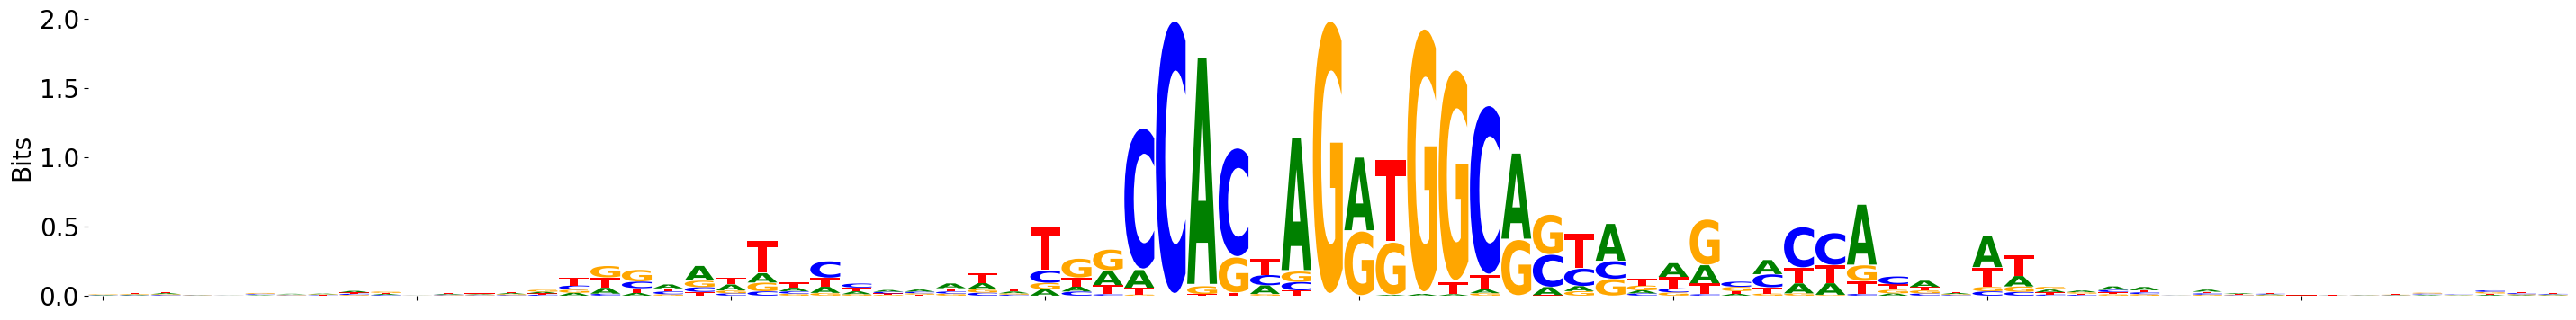

In [22]:
# saving logo
logo_height = 4
logo_width = 0.45
    
dna_prob = normalize(nt_count_table, axis=1, norm="l1")
dna_prob_df = pd.DataFrame(dna_prob, columns=["A", "C", "G", "T"])

logo_params = {"df": lm.transform_matrix(dna_prob_df, from_type="probability", to_type="information"),
            "figsize": (logo_width * dna_prob_df.shape[0], logo_height),
            "show_spines": False,
            "vpad": 0.02}

logo = lm.Logo(**logo_params)
logo.ax.set_ylabel("Bits", fontsize=20)
logo.ax.set_ylim(0, 2)
logo.ax.set_yticks([0, 0.5, 1, 1.5, 2], minor=False)
logo.ax.set_xticklabels([])

plt.yticks(fontsize=20)
# logo.fig.savefig("./plots/insertion_score_logo_TOP.pdf", format="pdf", bbox_inches="tight")